## Sequntial maximum likelihood estimation of infection rate parameters of coupled PHUs using negative Binomial 

shape of M is (4, 2, 2, 2720)


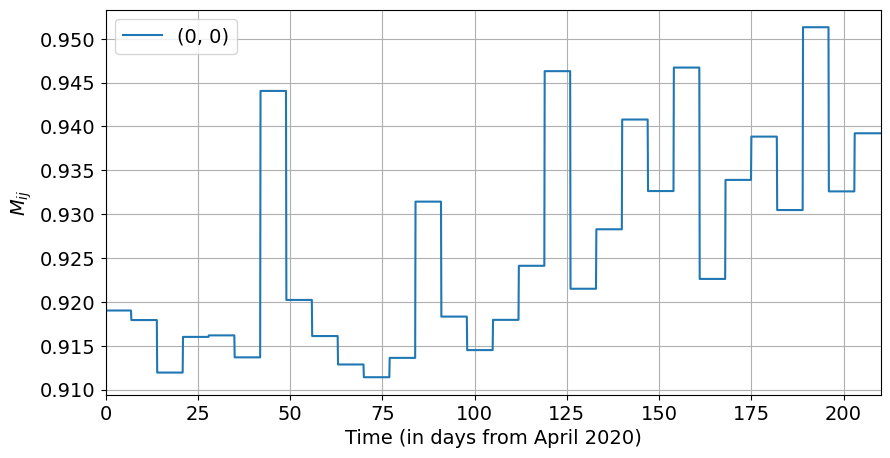

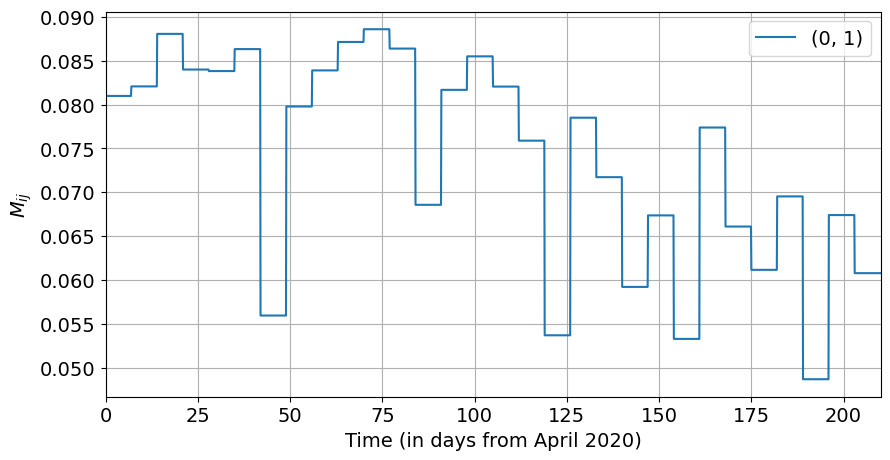

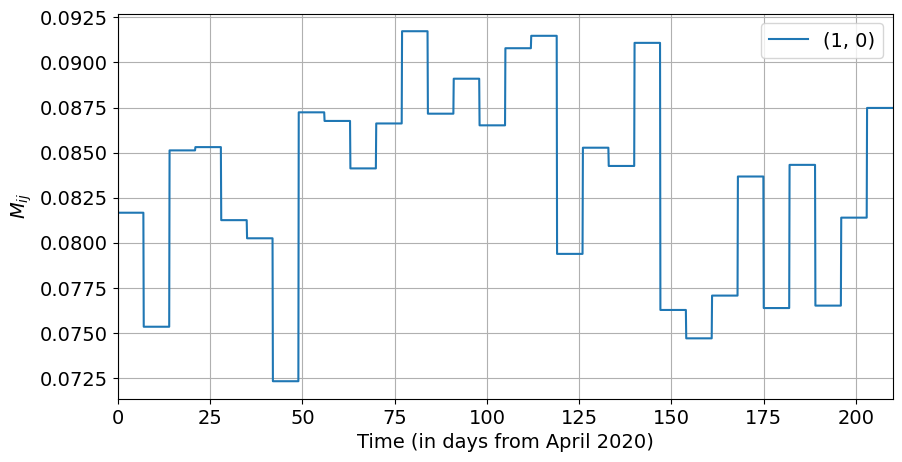

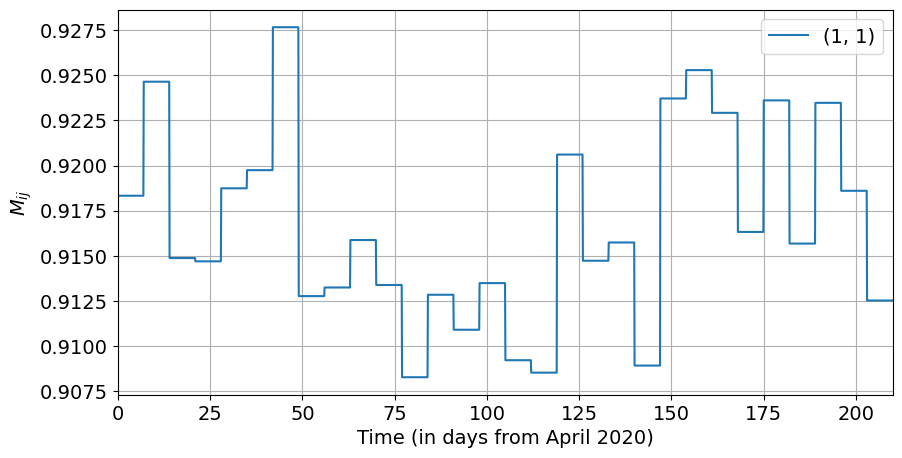

initial infected in PHU1 430.0
total population in PHU1 2794356.0
initial infected in PHU2  94.0
total population in PHU2  696992.0


In [1]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

dt = 0.1

##### CHANGE HERE #############
### Use the time up to which you need to estimate the parameters of sigmoid
dt = 0.1
tstart = 0
tlim = 210
t = np.arange(tstart, tlim, 1)

### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

ndiv = 1/dt

N_city = 2


##### CHANGE HERE #############

###### If you have your own data, load it here #######
### Currently loaded infection data from MOH, for April 2020 to March 2021

PHU_path = '/Users/sudhipv/documents/coupled_compartment/PHU_Data/'
datapath = '/Users/sudhipv/documents/coupled_compartment/data/'
figpath = '/Users/sudhipv/documents/coupled_compartment/figs/mle'
Mobility_path = '/Users/sudhipv/documents/coupled_compartment/mobility_tensor'

Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/04-Durham.csv'
target_file3 = f'{PHU_path}/34-York.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For noisy synthetic model output
I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))


# Stratification Tensor M
M = np.zeros((4,N_city,N_city,2720))

print("shape of M is", np.shape(M))


#####################################################################################


#  Below part of code is not well written - It uses the weekly data to generate the daily values 
# of mobility tensor and further saves in each time step. 

# Load the Mobility tensor values based on the Flow matrix

# Week number 13 (starting from 0) is April 6th.
# Week number 37 is Sep 21st.


Mtensor = np.zeros([52,2,2])

directory_path = f'{Mobility_path}/stochastic_Tor_Durham'
filesmobility = os.listdir(directory_path)

for ii in range(52):
    
      target_name_part = "Stochastic_matrix"+str(ii)+".dat"
    
      for file in filesmobility:
            if target_name_part == file:
              target_file = file
              break
      else:
        raise FileNotFoundError(f"Could not find any file containing '{target_name_part}'.")

      Mtensor[ii,:,:] = np.genfromtxt(f'{directory_path}/{target_file}', delimiter=' ')


### HARD CODED
mrange = int((272-0)/7) + 1


for w in range(mrange): # 39
   
    sw = 7*w
    
    if(w != mrange-1):
        tsw = np.linspace(sw, sw+6, int((1/dt)*6+1))
    else:
        tsw = np.linspace(sw, sw+5, int((1/dt)*5+1))


    for swk in range(len(tsw)):
        mindex = int((1/dt) * sw + swk)
        M[0,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        

    tsw2 = np.linspace(sw+6+dt, sw+7, int((1/dt)*1))
    for swk2 in range(1,len(tsw2)):
        mindex2 = mindex + swk2
        M[0,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]


mpl.rcParams.update({'font.size':14})
for i in range(N_city):
    for j in range(N_city):
        plt.figure(i+j+10,figsize=(10,5))
        plt.plot(tmoh, M[0,i,j,0:len(tmoh)], label=f'{i,j}')
        plt.legend(loc='best')
        plt.xlabel('Time (in days from April 2020)')
        plt.xlim([0,tlim])
        plt.ylabel('$M_{ij}$')
        plt.grid()
        plt.show()


#####################################################################################

#####Force of infection , Lambda
L_Force = np.zeros((len(tmoh),N_city))

 
total = np.zeros((N_city))

######## CHANGE HERE #################
total[0] = population_by_phu[29,1]

total[1] = population_by_phu[3,1]
#########################

# Initial Conditions
 
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
######## #################
R[0,0] = 0
D[0,0] = 0
N[0,0] = total[0]
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

######## CHANGE HERE #################
E[0,1] = Data[0,1]
I[0,1] = Data[0,1]

######## #################
R[0,1] = 0
D[0,1] = 0
N[0,1] = total[1]
S[0,1] = N[0,1] - E[0,1] - I[0,1] - R[0,1] - D[0,1]


I_model[0,0] = I[0,0]
I_model[0,1] = I[0,1]

######## CHANGE HERE #################
### Synthetic data - true solution
# file = np.genfromtxt(f'{datapath}/coupled_synth_data_r100.csv', delimiter=',')
# # file = np.loadtxt('./coupled_TD_synthetic_data.csv')
# I_synthetic = file[tstart:tlim]


### Real data - true solution
I_synthetic[:,0] =  Data[tstart:tlim,0]
I_synthetic[:,1] =  Data[tstart:tlim,1]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

print("initial infected in PHU2 ",I[0,1])

print("total population in PHU2 ",total[1])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


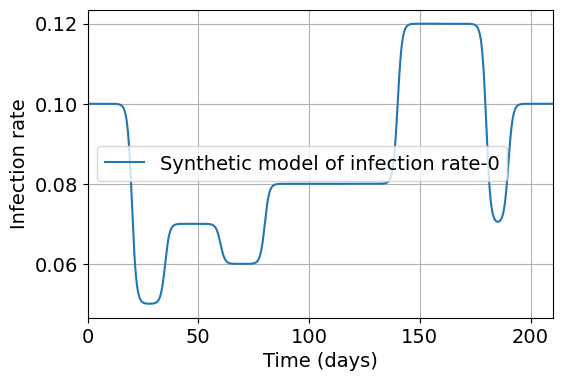

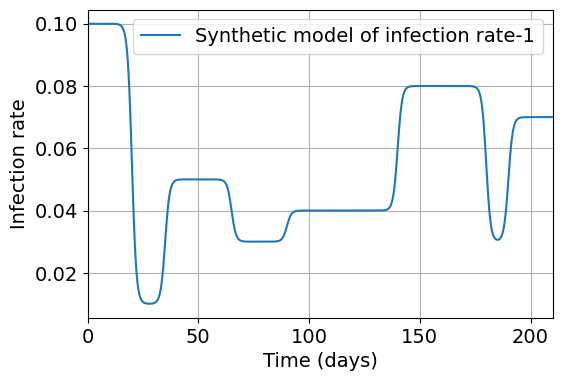

In [2]:

### UNCOMMNET THE RESPECTIVE PARAMETERS WHICH YOU ARE ESTIMATING

### FIRST INDEX REFERES TO THE PARAMETER AND SECOND INDEX TO THE PHU NUMBER
############ Model Parameters for generating Synthetic Data ####################

# original    
a01 =   0.15
a11 =  -0.1
t11 =  20
a21 =   0.05
t21 =  35
a31 =   -0.07
t31 = 60
a41 =  0.035
t41 = 80
a51 =  0.08
t51 = 140
a61 =  -0.065
t61 = 180
a71 =  0.025
t71 = 190
a81 =  -0.015
t81 = 230  


#### CHNAGE HERE ####

### Initial Guesses

a01 = 0.1
a11 = -0.05
a21 = 0.02
a31 = -0.01
a41 = 0.02
a51 = 0.04
a61 = -0.05
a71 = 0.03


beta_i[:,0] = a01 + a11/(1 + np.exp((t11-tmoh))) \
+ a21/(1 + np.exp((t21-tmoh))) \
+ a31/(1 + np.exp((t31-tmoh))) \
+ a41/(1 + np.exp((t41-tmoh))) \
+ a51/(1 + np.exp((t51-tmoh))) \
+ a61/(1 + np.exp((t61-tmoh))) \
+ a71/(1 + np.exp((t71-tmoh))) \
# + a81/(1 + np.exp((t81-tmoh))) 

beta_e[:,0] = beta_i[:,0]


################### Durham ##########################################################


# Original
a02 =   0.14
a12 =  -0.115
t12 =  20
a22 =   0.06
t22 =  35
a32 =   -0.05
t32 = 65
a42 =  0.035
t42 = 90
a52 =  0.06
t52 = 140
a62 =  -0.075
t62 = 180
a72 =  0.06
t72 = 190
a82 =  -0.025
t82 = 250

### Initial Guesses

a02 = 0.1
a12 = -0.09
a22 = 0.04
a32 = -0.02
a42 = 0.01
a52 = 0.04
a62 = -0.05
a72 = 0.04

beta_i[:,1] = a02  + a12/(1 + np.exp((t12-tmoh))) \
+ a22/(1 + np.exp((t22-tmoh))) \
+ a32/(1 + np.exp((t32-tmoh))) \
+ a42/(1 + np.exp((t42-tmoh))) \
+ a52/(1 + np.exp((t52-tmoh))) \
+ a62/(1 + np.exp((t62-tmoh))) \
+ a72/(1 + np.exp((t72-tmoh))) \
# + a82/(1 + np.exp((t82-tmoh))) 

beta_e[:,1] = beta_i[:,1]



################### York ##########################################################

# Original
# a0 =   0.12
# a1 =  -0.1
# t1 =  20
# a2 =   0.08
# t2 =  35
# a3 =   -0.04
# t3 = 50
# a4 =  0.07
# t4 = 130
# a5 = -0.04
# t5 = 200
# a6 =  0
# t6 = 180
# a7 =  0
# t7 = 230


# beta_i[:,2] = a0 + a1/(1 + np.exp((t1-t))) +  a2/(1 + np.exp((t2-t))) + a3/(1 + np.exp((t3-t))) + a4/(1 + np.exp((t4-t))) + a5/(1 + np.exp((t5-t)))  + a6/(1 + np.exp((t6-t)))  + a7/(1 + np.exp((t7-t))) 
# beta_e[:,2] = beta_i[:,2]


################### Peel ##########################################################

# original
# a0 =   0.15
# a1 =  -0.1
# t1 =  20
# a2 =   0.05
# t2 =  35
# a3 =   -0.07
# t3 = 60
# a4 =  0.035
# t4 = 80
# a5 =  0.08
# t5 = 140
# a6 =  -0.09
# t6 = 180
# a7 =  0.065
# t7 = 190
# a8 =  -0.035
# t8 = 235


# beta_i[:,1] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
# beta_e[:,1] = beta_i[:,1]





######## ADD THE PARAMETERS TO BE ESTIMATED #######

param = [a01,a11,a21,a31,a41,a51,a61,a71, a02,a12,a22,a32,a42,a52,a62,a72]


for ff in range(N_city):
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.set_xlim([0,tlim])
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Infection rate') 
    ax2.grid()
    plt.plot(tmoh, beta_i[:,ff], label=f'Synthetic model of infection rate-{ff}')
    # plt.plot(tmoh, beta_i[:,1], label='Synthetic model of infection rate-2')
    ax2.legend(loc='best')
    # plt.savefig('./figs/beta_true.pdf',  bbox_inches='tight')
    plt.show()




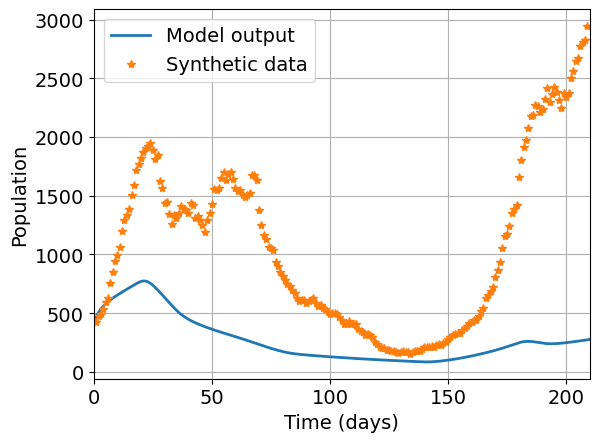

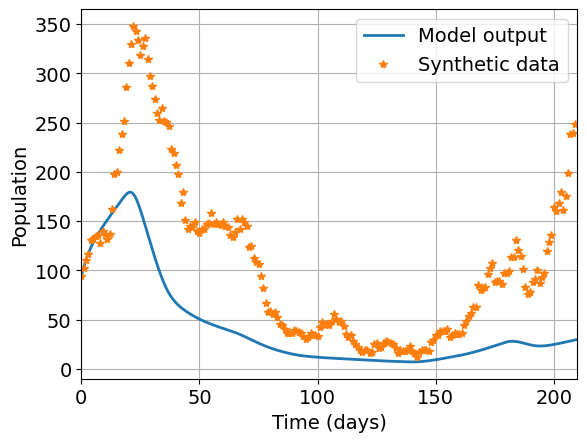

In [3]:
##### LOAD PRE GENERATED NOISY DATA #########

idxmoh = 0

#### With mobility tensor   

for kk in range(1,len(tmoh)):

    for gg in range(0,N_city):

        L_sum = 0
        for ll in range(0,N_city):

            Nlm = 0
            L_cityinf = 0
            
            for mm in range(0,N_city):
                Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]


                L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


            L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


        L_Force[kk-1,gg] = L_sum


        S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
        E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
        I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
        R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
        D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
        N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


        # if( kk%ndiv == 0):
        #     idxmoh = int(kk/ndiv)
        #     if(tstart != 0):
        #         if(idxmoh >= tstart and idxmoh < tlim):
        #             I_model[idxmoh-tstart,gg] = I[kk,gg]
        #     else:
        #         idxmoh = int(kk/ndiv)
        #         I_model[idxmoh,gg] = I[kk,gg]

        

for hh in range(N_city):
    plt.plot(tmoh, I[:,hh], '-',linewidth=2, label='Model output')
    plt.plot(t, I_synthetic[:,hh], '*', markersize=6, label='Synthetic data')
    plt.legend(loc='best')
    plt.xlabel('Time (days)')
    plt.xlim([0,tlim])
    plt.ylabel('Population')
    plt.grid()
    # plt.savefig(filepath)
    plt.show()





### Computing the log likelihood for coupled PHUs 

In [4]:


from scipy.optimize import least_squares, minimize, OptimizeResult, dual_annealing, shgo



#### CHANGE HERE 
### decrease p to reduce r and thus dispersion, increase p to get more dispersion
r = 100 ### Number of success


def loglikelihood(param):


    Lsum = 0

    loglik = 0

############### CHANGE HERE #################
###### Update the model of beta to include the parameter which needs 
# to be estimated along with the known paramters until that time
 

    beta_i[:,0] = param[0]  + param[1]/(1 + np.exp((t11-tmoh))) \
    +  param[2]/(1 + np.exp((t21-tmoh))) \
    + param[3]/(1 + np.exp((t31-tmoh))) \
    + param[4]/(1 + np.exp((t41-tmoh))) \
    + param[5]/(1 + np.exp((t51-tmoh))) \
    + param[6]/(1 + np.exp((t61-tmoh))) \
    + param[7]/(1 + np.exp((t71-tmoh)))
    # + param[8]/(1 + np.exp((t81-tmoh)))
    beta_e[:,0] = beta_i[:,0]


    beta_i[:,1] = param[8]  + param[9]/(1 + np.exp((t12-tmoh))) \
    + param[10]/(1 + np.exp((t22-tmoh))) \
    + param[11]/(1 + np.exp((t32-tmoh))) \
    + param[12]/(1 + np.exp((t42-tmoh))) \
    + param[13]/(1 + np.exp((t52-tmoh))) \
    + param[14]/(1 + np.exp((t62-tmoh))) \
    + param[15]/(1 + np.exp((t72-tmoh))) 
    # + param[17]/(1 + np.exp((t82-tmoh)))
    beta_e[:,1] = beta_i[:,1]


   

#### With mobility tensor   

    for kk in range(1,len(tmoh)):

        for gg in range(0,N_city):

            L_sum = 0
            for ll in range(0,N_city):

                Nlm = 0
                L_cityinf = 0
                
                for mm in range(0,N_city):
                    Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                    L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


                L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


            L_Force[kk-1,gg] = L_sum


            S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
            E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
            I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
            R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
            D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
            N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


            ## For collecting the model output only at data points

            if( kk%ndiv == 0):
                
                idxmoh = int(kk/ndiv)

                if(tstart !=0):
                    if(idxmoh >=tstart and idxmoh<tlim):

                        logNfac = 0.0

                        if int(I_synthetic[idxmoh-tstart,gg]) != 0:
                            logNfac = np.sum(np.log(np.arange(0,int(I_synthetic[idxmoh-tstart, gg]),1)+1)) #log factorial

                        p = r /(I[kk,gg] + r)
                        # print(r)
                        loglik = loglik + (math.lgamma(I_synthetic[idxmoh-tstart,gg]+r) - (logNfac + math.lgamma(r)) + r*np.log(p) + I_synthetic[idxmoh-tstart,gg]*np.log(1-p))


                else:

                    logNfac = 0.0

                    if int(I_synthetic[idxmoh,gg]) != 0:
                        logNfac = np.sum(np.log(np.arange(0,int(I_synthetic[idxmoh, gg]),1)+1)) #log factorial

                    p = r /(I[kk,gg] + r)
                    # print(r)
                    loglik = loglik + (math.lgamma(I_synthetic[idxmoh,gg]+r) - (logNfac + math.lgamma(r)) + r*np.log(p) + I_synthetic[idxmoh,gg]*np.log(1-p))
 
        

    return -loglik



options_bfgs = {
    'gtol': 1e-12,  # Gradient norm tolerance for convergence
    'disp': True,  # Display convergence messages
    'eps': 1e-8
}

options_nm = {
    'disp': True,  # Display convergence messages
}


### To be used for Synthetic data when you know true parameter values
# errors = []
# iterations = []

# def callback(xk):
#     print(f"Current parameter values: {xk}")
#     # err = np.linalg.norm(xk - trueparam)/np.linalg.norm(trueparam)
#     # print("relative error is", err)
#     errors.append(err)
#     iterations.append(len(errors))


 
val = 0.05
bounds = [(a01-val, a01+val), (a11-val, a11+val), (a21-val, a21+val), (a31-val, a31+val), (a41-val, a41+val), (a51-val, a51+val), (a61-val, a61+val), (a71-val, a71+val), \
          (a02-val, a02+val), (a12-val, a12+val), (a22-val, a22+val), (a32-val, a32+val), (a42-val, a42+val), (a52-val, a52+val), (a62-val, a62+val), (a72-val, a72+val), ]
          

 

res = minimize(loglikelihood, param, method='L-BFGS-B', options = options_bfgs)



print(res)
param_mle = res.x

print("initial guesses" ,param)
print("MLE value", res.x)



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96296D+04    |proj g|=  6.24938D+06

At iterate    1    f=  1.05202D+04    |proj g|=  5.44069D+05

At iterate    2    f=  9.89545D+03    |proj g|=  3.75296D+05

At iterate    3    f=  9.39018D+03    |proj g|=  3.74905D+05

At iterate    4    f=  9.08958D+03    |proj g|=  4.52102D+05

At iterate    5    f=  6.64988D+03    |proj g|=  7.67997D+05

At iterate    6    f=  5.40341D+03    |proj g|=  4.40555D+05

At iterate    7    f=  4.99050D+03    |proj g|=  8.69703D+04

At iterate    8    f=  4.94850D+03    |proj g|=  7.55012D+04

At iterate    9    f=  4.87238D+03    |proj g|=  1.35854D+05

At iterate   10    f=  4.69802D+03    |proj g|=  2.57957D+05

At iterate   11    f=  4.35560D+03    |proj g|=  3.91558D+05

At iterate   12    f=  3.86086D+03    |proj g|=  4.27191D+05

At iterate   13    f=  3.0

#### Using MLE values to predict infections

[ 0.15530582 -0.11440652  0.068809   -0.06500159  0.02018632  0.08993903
 -0.03972402 -0.01715194  0.1114486  -0.06963404  0.00147462 -0.0326881
  0.03587561  0.03286086 -0.11130769  0.11692651]


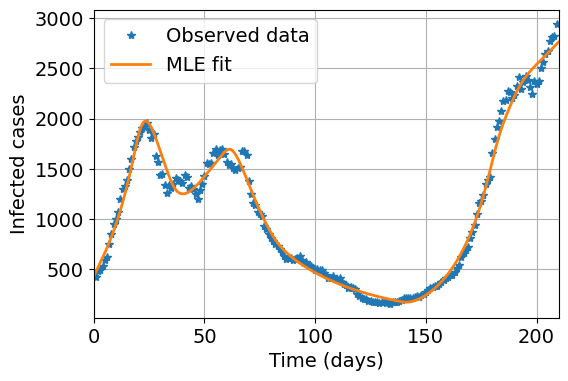

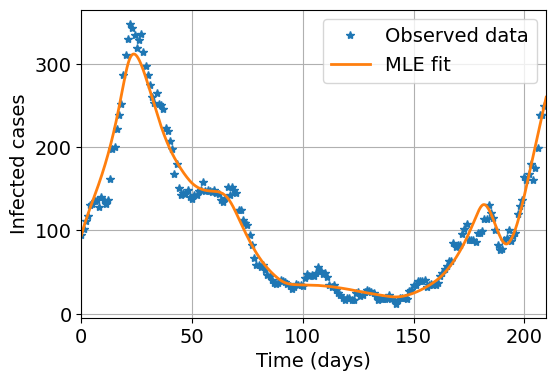

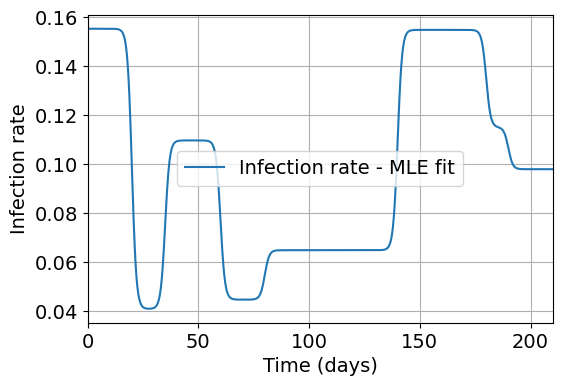

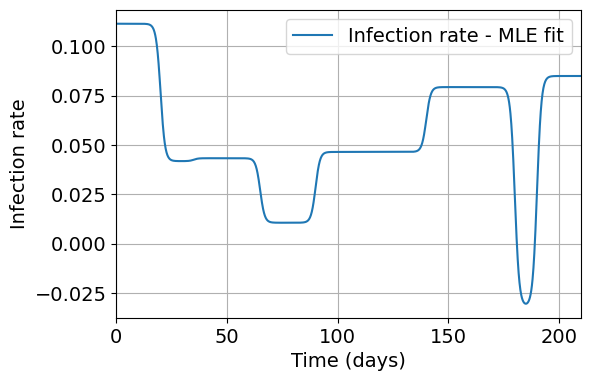

In [6]:
print(param_mle)


beta_i[:,0] = param_mle[0] + param_mle[1]/(1 + np.exp((t11-tmoh))) \
+ param_mle[2]/(1 + np.exp((t21-tmoh))) \
+ param_mle[3]/(1 + np.exp((t31-tmoh))) \
+ param_mle[4]/(1 + np.exp((t41-tmoh))) \
+ param_mle[5]/(1 + np.exp((t51-tmoh))) \
+ param_mle[6]/(1 + np.exp((t61-tmoh))) \
+ param_mle[7]/(1 + np.exp((t71-tmoh))) 
# + param_mle[8]/(1 + np.exp((t81-tmoh))) 


beta_e[:,0] = beta_i[:,0]

beta_i[:,1] = param_mle[8]  + param_mle[9] /(1 + np.exp((t12-tmoh))) \
+ param_mle[10]/(1 + np.exp((t22-tmoh))) \
+ param_mle[11]/(1 + np.exp((t32-tmoh))) \
+ param_mle[12]/(1 + np.exp((t42-tmoh))) \
+ param_mle[13]/(1 + np.exp((t52-tmoh))) \
+ param_mle[14]/(1 + np.exp((t62-tmoh))) \
+ param_mle[15]/(1 + np.exp((t72-tmoh))) 
# + param_mle[17] /(1 + np.exp((t81-tmoh)))

beta_e[:,1] = beta_i[:,1]


idxmoh = 0

#### With mobility tensor   

for kk in range(1,len(tmoh)):

    for gg in range(0,N_city):

        L_sum = 0
        for ll in range(0,N_city):

            Nlm = 0
            L_cityinf = 0
            
            for mm in range(0,N_city):
                Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


            L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


        L_Force[kk-1,gg] = L_sum


        S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
        E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
        I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
        R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
        D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
        N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


        
## load saved true infection data

# I_truth = np.zeros((len(tmoh),N_city))

# file1 = np.genfromtxt(f'{datapath}/coupled_toronto_synthetic_truth_all.csv', delimiter=',')
# I_truth[:,0] = file1[0:len(tmoh),2]


# file2 = np.genfromtxt(f'{datapath}/coupled_durham_synthetic_truth_all.csv', delimiter=',')
# I_truth[:,1] = file2[0:len(tmoh),2]


for dd in range(N_city):
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    plt.plot(t[:tlim], I_synthetic[tstart:tlim,dd], '*', markersize=6, label='Observed data')
    plt.plot(tmoh[:int(tlim*ndiv)], I[:int(tlim*ndiv),dd], '-',linewidth=2, label='MLE fit')
    # plt.plot(tmoh[:int(tlim*ndiv)], I_truth[:,dd], '-',linewidth=2, label='True model')
    # plt.plot(t[:tlim], Data[:tlim,dd], '-',linewidth=2, label='True model')
    plt.legend(loc='best')
    plt.xlabel('Time (days)')
    plt.xlim([0,tlim])
    plt.ylabel('Infected cases')
    plt.grid()
    plt.savefig(f'{figpath}/MLE_fit_coupled_NB_REAL_{dd}.pdf', bbox_inches='tight')
    plt.show()


## load saved true model of beta

# beta_truth = np.zeros((len(tmoh),N_city)) 

# file = np.genfromtxt(f'{datapath}/coupled_true_beta.csv', delimiter=',')
# beta_truth = file[0:len(tmoh)]


for gg in range(N_city):
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.set_xlim([0,tlim])
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Infection rate') 
    ax2.grid()
    plt.plot(tmoh, beta_i[:,gg], label='Infection rate - MLE fit')
    # plt.plot(tmoh, beta_truth[:,gg], label='Infection rate - Truth')
    plt.legend(loc='best')
    plt.savefig(f'{figpath}/beta_fit_coupled_NB_REAL_{gg}.pdf',  bbox_inches='tight')
    plt.show()

